/var/folders/93/mkk4_0n92mqfw0hk1dg6wxlm0000gn/T/ipykernel_48185/2326633142.py:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=data.values.T, var=pd.DataFrame(index=data.index), obs=pd.DataFrame(index=data.columns))
/Users/georgye/miniforge3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/georgye/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/93/mkk4_0n92mqfw0hk1dg6wxlm0000gn/T/ipykernel_48185/2326633142.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy 

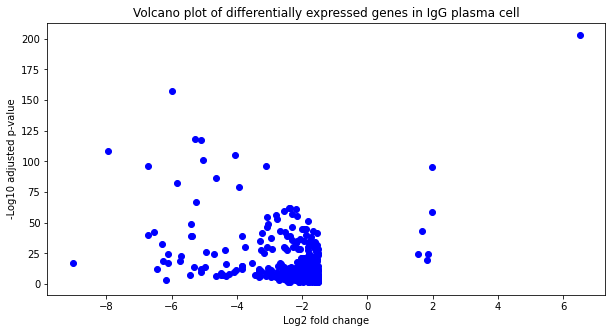

Significant genes for IgG plasma cell:


/Users/georgye/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/93/mkk4_0n92mqfw0hk1dg6wxlm0000gn/T/ipykernel_48185/2326633142.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['neg_log_pvals_adj'] = -np.log10(df_significant['pvals_adj'])


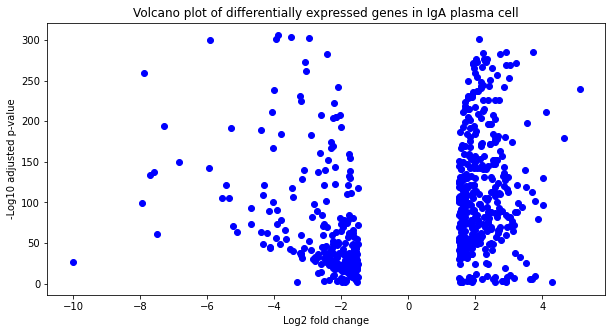

Significant genes for IgA plasma cell:
1122
                 naive B cell  naive B cell  naive B cell  naive B cell  \
ENSG00000070961           0.0           0.0           0.0           0.0   
ENSG00000100644           0.0           0.0           0.0           0.0   
ENSG00000090621           0.0           0.0           0.0           0.0   
ENSG00000146416           0.0           0.0           0.0           0.0   
ENSG00000151366           0.0           0.0           0.0           0.0   
...                       ...           ...           ...           ...   
ENSG00000186654           0.0           0.0           0.0           0.0   
ENSG00000162998           0.0           0.0           0.0           0.0   
ENSG00000151876           0.0           0.0           0.0           0.0   
ENSG00000274215           0.0           0.0           0.0           0.0   
ENSG00000186687           0.0           0.0           0.0           0.0   

                 naive B cell  naive B cell  naive B ce

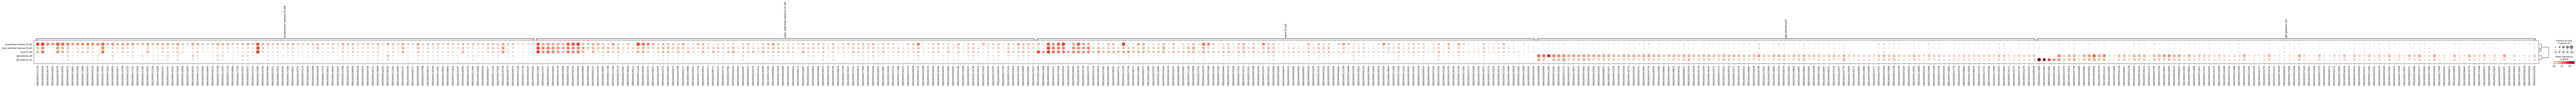

In [5]:
import os
import pandas as pd
import re
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv(os.path.dirname(os.path.abspath('')) + '/SplatterSim-mainScDesign2/scDesign2/data/bcells_100_250_1400_1900_1350_09_05_02_01_.csv', sep=',', index_col=0) #on_bad_lines='skip' the first row
# data = pd.read_csv(os.path.dirname(os.path.abspath('')) + '/SplatterSim-mainScDesign2/scDesign2/data/bcells_1400_1900_1700_05_02_01.csv', sep=',', index_col=0) #on_bad_lines='skip' the first row
data.columns = [re.sub(r"\.\d+$", "", string) for string in data.columns]
adata = sc.AnnData(X=data.values.T, var=pd.DataFrame(index=data.index), obs=pd.DataFrame(index=data.columns))

adata.obs['cell_type'] = data.columns
# Normalize the counts.
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data.
sc.pp.log1p(adata)
adata.raw = adata
all_groups = ['unswitched memory B cell', 'naive B cell', 'class switched memory B cell', 'IgG plasma cell', 'IgA plasma cell']
sc.tl.rank_genes_groups(adata, 'cell_type', groups=all_groups, method='wilcoxon')
groups=['IgG plasma cell', 'IgA plasma cell']
# Extract the results.
significant_genes_total = []
for group in groups:
    names = adata.uns['rank_genes_groups']['names'][group]
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][group]
    pvals = adata.uns['rank_genes_groups']['pvals'][group]
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][group]

    # Combine the above arrays into one results dataframe.
    results_df = pd.DataFrame({
        'names': names,
        'logfoldchanges': logfoldchanges,
        'pvals': pvals,
        'pvals_adj': pvals_adj
    })

    # Filter genes by adjusted p-value (you may adjust the threshold)
    df_significant = results_df.loc[(results_df['pvals_adj'] < 0.05) & (np.abs(results_df['logfoldchanges']) > 1.5), :]

    # Create a new column for -log10 of the adjusted p-value
    df_significant['neg_log_pvals_adj'] = -np.log10(df_significant['pvals_adj'])

    # Create the volcano plot
    plt.figure(figsize=(10, 5))
    plt.scatter(df_significant['logfoldchanges'], df_significant['neg_log_pvals_adj'], c='blue')
    plt.title(f'Volcano plot of differentially expressed genes in {group}')
    plt.xlabel('Log2 fold change')
    plt.ylabel('-Log10 adjusted p-value')
    plt.show()


    # Get the names of the significant genes
    significant_genes = df_significant['names'].tolist()
    print(f'Significant genes for {group}:')
    significant_genes_total += significant_genes

# Convert row indices to a set to remove duplicates
row_indices = list(set(significant_genes_total))

# Create a boolean mask based on the row indices
mask = data.index.isin(row_indices)

# Set rows with the specified indices to 0
data.loc[mask] = 0

sc.pl.rank_genes_groups_dotplot(adata, n_genes=100, groupby='cell_type')

data.to_csv(os.path.dirname(os.path.abspath('')) + '/SplatterSim-mainScDesign2/scDesign2/bcells_100_250_1400_1900_1350_09_05_02_01_.csv', sep=',')
# data.to_csv(os.path.dirname(os.path.abspath('')) + '/SplatterSim-mainScDesign2/scDesign2/bcells_1400_1900_1700_05_02_01_de_plasma.csv', sep=',')

